In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
documents_train = pd.read_csv("data_round_1/documents_en_train.csv")
sentences_train = pd.read_csv("data_round_1/sentences_en_train.csv")

documents_val = pd.read_csv("data_round_1/documents_en_val.csv")
sentences_val = pd.read_csv("data_round_1/sentences_en_val.csv")

documents_test = pd.read_csv("data_round_1/documents_en_test.csv")
sentences_test = pd.read_csv("data_round_1/sentences_en_test.csv")

#immap_sector_name_to_id.json

## Investigate Document data

In [3]:
documents_train.head()

,project_name,country_code,lang_code,doc_id,doc_text,doc_url
0,IMMAP/DFS Syria,SYR,en,48582,This website uses cookies to improve your expe...,https://www.syriahr.com/en/203844/
1,IMMAP/DFS Syria,SYR,en,41032,Please enable Cookies and reload the page.\n\n...,https://www.syriahr.com/en/187230/
2,IMMAP/DFS Burkina Faso,BFA,en,41306,When Burkina Faso’s government called for civi...,https://www.thenewhumanitarian.org/news-featur...
3,IMMAP/DFS Syria,SYR,en,43779,DAMASCUS – The United Nations World Food Progr...,https://reliefweb.int/report/syrian-arab-repub...
4,IMMAP/DFS Nigeria,NGA,en,42212,Overview The continuation of conflict in North...,https://reliefweb.int/sites/reliefweb.int/file...


## Investigate full text data

In [4]:
sentences_train.head()

,doc_id,sentence_id,sentence_text,is_relevant,sector_ids
0,51657,0,New Salesian youth center in La Cecilia distri...,0,[]
1,51657,1,Armenia is at the center of the Colombian coff...,0,[]
2,51657,2,The new youth center has served more than 100 ...,0,[]
3,51657,3,The Salesian youth center was developed in res...,0,[]
4,51657,4,Many of these youth come from poor families an...,0,[]


In [5]:
counts = sentences_train[["sentence_id", "doc_id"]].groupby("doc_id").count()
print("Median sentence lenght of document:", np.median(counts))
counts

Median sentence lenght of document: 24.0


,sentence_id
doc_id,
34512,126
34513,296
34547,750
34549,65
34550,36
...,...
51845,4
51850,22
51851,3


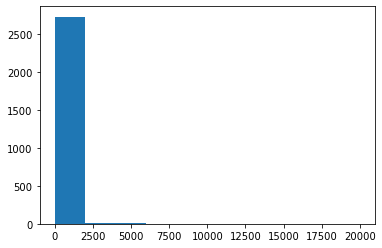

In [6]:
import matplotlib.pyplot as plt
counts = sentences_train.groupby("doc_id").count()
x = counts["sentence_id"]
plt.hist(x)
plt.show()

In [7]:
all_sectors = []
string_list = ["[", "]", ",", " "]
for topics in sentences_train["sector_ids"]:
    for topic in topics:
        if topic not in string_list:
            all_sectors.append(topic)        

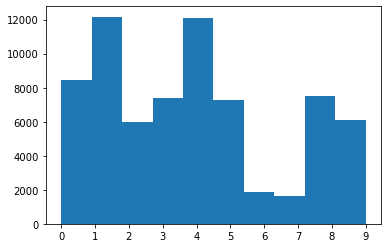

In [8]:
plt.hist(sorted(all_sectors))
plt.show()

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4fd50739-29f7-46cb-8aab-a9724cfcd877' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>